In [1]:
import sys
import logging
import math

import glob
import os
import sys

import pandas as pd
import numpy as np

from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters


import pandas as pd
import numpy as np
from tsfresh import extract_features

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

%matplotlib inline

matplotlib.style.use("Solarize_Light2")

sys.path.insert(0, "/opt/vssexclude/personal/kaggle/k_tab_aug")

In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [3]:
import src.config.constants as constants
import src.munging as process_data
import src.viz as viz
import src.common as common
import src.config.tsfresh_config as tsfresh_config

In [4]:
logger = logging.getLogger()

In [5]:
train_df, test_df, combined_df = process_data.read_processed_data(logger=logger, data_dir=constants.PROCESSED_DATA_DIR)

In [6]:
combined_df = pd.concat([train_df.drop("loss", axis=1), test_df])

In [7]:
combined_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.272701,16.685699,30.359900,1.267300,0.392007,1.09101,1.96874,1.874640,117.286003,6.716200,0.985656,0.973428,4004232,0.377896,1.033820,0.574531,0.122371,8.18617,1517.829956,3.13219,0.112836,5.01868,116.765999,10891,8.193660,5.79715,1.09999,14.86840,-0.275434,0.915721,167.800003,-7.534140,4.23632,1.629560,1.144400,-0.303139,4.092090,3.22617,0.074799,0.259497,289.492004,327.464996,5.389310,7.39479,-0.489950,20.292299,2.45660,1.447720,-10639.000000,85.600502,-0.178513,2815,-234.772003,1.83317,88.560501,0.367916,8.575340e+09,70.973297,0.380057,0.031812,1.09527,0.563482,0.122689,1.160720,1.69391,1.07217,65.154297,0.022504,-5.606800,1.798660,0.528068,6696.299805,-0.562078,1.301020,6.71624,1.143470,2.29983,0.010485,-0.127223,0.231086,4.51614,0.594494,397,0.264022,8.68790,15.070100,0.376622,-42.439899,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980
1,0.784462,145,-0.463845,-0.530421,27324.900391,3.475450,160.498001,0.828007,3.735860,1.28138,-2.73947,-0.529506,157.669998,0.696384,1.441230,0.159056,23567462,-0.089583,-0.711628,-1.045860,0.139920,3.69294,-123.353996,7.74097,-0.852302,8.51025,161.175003,87801,12.020200,1.78393,1.23100,10.14970,-0.018724,1.011280,127.401001,11.821400,5.99681,-0.953850,1.379370,1.079530,0.711923,2.90602,0.051206,0.755122,140.893005,29.525200,14.229600,3.53213,-0.405681,42.535702,1.43533,0.939771,138312.000000,59.881001,-0.070959,1435,1046.880005,1.56770,29.430599,2.455150,4.518200e+09,75.560204,1.987990,0.318177,1.14901,0.723574,0.184821,-0.348303,-7.17633,1.46258,43.112099,-0.060801,64.045502,2.358450,5.759690,3958.139893,1.576610,-1.241790,5.91412,0.959826,2.56631,0.000652,-0.335617,-0.271723,5.10319,8.706220,98,0.210513,7.86416,3.371900,0.147973,-184.132004,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383
2,0.317816,19,-0.432571,-0.382644,1383.260010,19.712900,31.102600,-0.515354,34.430801,1.24210,2.90180,-0.960340,118.589996,7.696420,1.488760,0.387277,235760,0.055568,0.268560,0.718133,0.027133,11.67340,270.247009,3.44051,-0.679071,13.37810,150.362000,14173,1.699540,7.04728,1.10513,7.62871,0.685721,0.809485,120.064003,194.427002,6.77866,0.634136,0.934386,0.926980,0.741116,2.42205,0.260362,0.626639,369.579010,370.023987,4.488930,7.84290,1.196010,43.534302,2.59182,1.256710,168881.000000,83.841904,2.713230,2911,23256.900391,3.91896,97.557800,4.385380,8.444970e+08,99.493301,5.098040,0.258909,1.16878,0.049053,0.173547,0.937000,2.05947,1.22245,50.226700,-0.026215,71.684898,2.434170,1.904560,27165.800781,-0.773223,-1.833390,4.98548,1.170870,1.17201,0.016848,-0.235581,-0.724935,3.22565,4.170990,105,-0.155451,8.91829,0.186334,0.335985,7.437210,37.218102,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550
3,0.210753,17,-0.616454,0.946362,-119.252998,4.082350,185.257004,1.383310,-47.521400,1.09130,-1.51200,-1.292340,125.460999,7.343230,-3.092390,0.713795,1146032,0.326534,0.454842,0.219958,0.037982,5.15195,4893.859863,6.89751,-0.830552,4.43184,132.854996,77147,32.808998,4.06390,1.11911,3.91776,0.500353,0.206448,120.411003,233.537003,7.75131,0.625762,-1.940810,1.333210,-5.793170,1.56512,0.309483,0.134558,84.863701,24.335300,4.871200,2.55104,-0.372300,14.896000,1.10013,0.892193,17006.599609,78.407799,0.425686,1723,375.239990,1.94539,98.150002,-0.109164,3.543970e+09,60.808201,2.357590,0.239080,1.16116,0.535797,0.222185,1.163120,2.36343,1.41530,116.181999,0.018674,55.442799,2.228240,4.303600,2643.760010,-1.666320,0.792398,6.45162,1.077330,2.90676,

In [8]:
combined_df_min_max = combined_df.copy()
for name in combined_df.columns:
    mm = MinMaxScaler()
    combined_df_min_max.loc[:, name] = mm.fit_transform(combined_df[[name]])

In [9]:
combined_df_min_max = process_data.change_dtype(
        logger, combined_df_min_max, np.float64, np.float32
    )

<AxesSubplot:>

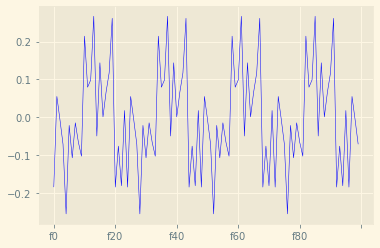

In [10]:
import statsmodels.tsa.api as tsa

decomposition = tsa.seasonal_decompose(combined_df_min_max.iloc[100000], model="additive", period=24)
decomposition.seasonal.plot(color="blue", linewidth=0.5)

<AxesSubplot:>

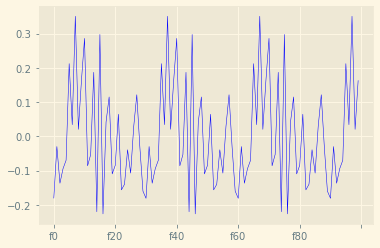

In [23]:
import statsmodels.tsa.api as tsa

decomposition = tsa.seasonal_decompose(combined_df_min_max.iloc[7], model="additive", period=30)
decomposition.seasonal.plot(color="blue", linewidth=0.5)

<AxesSubplot:>

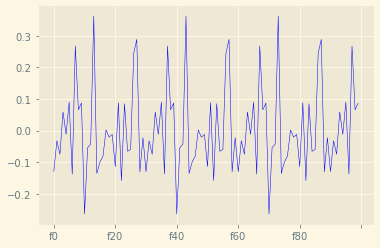

In [24]:
import statsmodels.tsa.api as tsa

decomposition = tsa.seasonal_decompose(combined_df_min_max.iloc[10], model="additive", period=30)
decomposition.seasonal.plot(color="blue", linewidth=0.5)

In [22]:
train_df[train_df.loss == 5]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.177120,11,-0.361778,0.492327,-9.015740,6.569380,211.419998,-0.841209,16.011499,1.20180,-0.444614,-0.583293,149.360001,10.99600,1.054580,1.005630,103416,0.086591,-0.420537,-0.047958,0.070865,7.522690,4052.000000,5.378540,0.684339,4.684220,149.222000,79702,-0.810998,6.39633,1.19600,4.37607,-0.752381,0.924905,128.690994,669.174011,5.35996,0.375028,1.23238,1.057730,8.679720,2.345940,0.120130,0.554459,105.901001,574.702026,5.28435,5.860520,0.647126,37.234600,2.75974,1.757050,-130.682007,45.583801,-0.213989,1589,3253.360107,1.52407,99.321297,0.363784,1.616940e+09,89.296997,3.64108,0.213598,1.15619,0.647356,0.306565,1.942480,-1.534300,1.208330,158.960999,-0.120139,61.697102,1.62087,1.38188,32339.300781,-1.286000,0.968489,8.11460,1.16263,1.37341,0.002908,-0.731649,0.202771,2.42207,5.31318,20,-0.120584,12.97530,0.443785,0.406716,-5.514940,42.106499,1.797850,-0.197997,5.95310,2.69559,0.487619,1.230210,7.070880,5
10,0.669549,61,0.879753,0.438353,8656.169922,7.676910,89.022499,1.153630,10.546900,1.18057,-1.251160,-1.184540,151.449005,15.28010,4.912940,0.307347,1333831,0.142035,0.397236,0.175944,0.046386,9.032450,3762.959961,17.472601,-0.715906,6.906260,165.589996,80467,6.664660,7.57387,1.16557,7.06875,-1.174930,1.836820,128.636002,357.623993,3.04708,-0.609249,2.22179,0.235578,-16.623699,2.638580,0.122793,0.520778,26.167500,65.742203,6.76227,0.463518,-0.265637,82.481201,1.45117,1.376150,-14175.400391,68.040398,0.128813,1330,11764.299805,2.54174,45.889400,1.874680,2.468700e+09,45.747398,7.40247,0.284737,1.20277,0.622877,0.115113,1.169760,-5.856290,0.931618,22.480700,-0.133252,51.383900,3.38721,4.46875,12654.000000,0.524652,2.897840,3.07121,1.31206,2.08493,0.030290,-0.718608,0.144995,4.36527,4.19184,54,0.246297,11.75100,11.018500,0.841252,293.631989,12.591200,1.418490,1.001560,3.69295,1.62340,0.537162,3.459670,5.181160,5
11,0.162469,106,0.373867,-0.923271,1808.150024,9.719000,10.184600,-0.820630,3.793940,1.38797,1.442990,-0.751205,155.033997,5.53310,-0.805521,0.186588,23141082,-0.027529,0.374166,0.453152,0.491653,2.977960,8531.490234,2.862590,-1.175460,2.672590,129.813995,79118,15.312200,4.14336,1.21936,7.25590,0.327795,2.448600,151.718994,12.330600,2.68830,-0.546640,1.10751,0.523047,8.672270,1.629690,0.113177,0.290781,21.403999,53.130501,7.48343,6.178720,0.759842,18.556999,1.56535,1.709140,62534.898438,86.972801,0.286656,881,-51.166901,1.45754,65.452003,1.770890,3.860090e+08,66.330399,5.50206,0.321122,1.23328,0.128773,0.217277,-0.440715,6.166190,-0.507549,25.116899,-0.131196,82.209900,2.32612,3.55847,739.702026,-0.905487,1.061180,7.46470,1.12689,1.35546,0.002168,-0.530808,-0.308590,2.81434,4.05414,63,0.123676,5.22433,7.087850,0.581062,2168.959961,12.380900,3.499070,0.502862,17.43070,2.62917,0.764931,1.521310,6.516290,5
67,0.494184,24,-0.364878,-0.045059,86.421898,6.202650,6.866480,0.460696,-6.382820,1.15167,-5.932880,0.713065,125.709999,2.04271,1.053730,0.307962,223303,0.006885,-0.229643,-1.331440,0.020499,2.391020,343.694000,9.044080,-0.844982,-0.590957,132.268005,12929,0.413885,4.14081,1.31685,6.55005,1.204860,1.194640,137.921997,65.797798,3.75079,0.960971,1.32029,1.007870,0.748906,1.785450,0.250925,0.800739,236.481003,173.949005,3.15356,8.141030,-0.785538,51.348000,1.51605,0.871185,-3464.659912,87.365997,0.514673,-48,10870.200195,1.65843,92.377197,1.070580,1.242340e+09,40.172699,1.12641,0.452773,1.18359,0.057563,0.271770,1.009770,4.681570,1.183060,70.193001,0.107561,61.838699,2.48807,3.99497,52.998299,-0.671760,2.364200,4.18467,1.08075,1.55626

In [11]:
combined_df_min_max.shape

(400000, 100)

In [12]:
def flatten_df(df):
    flat_array = df.values.flatten()
    flat_df = pd.DataFrame(flat_array)
    flat_df.columns = ["loan"]
    flat_df["row_no"] = flat_df.reset_index().index
    flat_df = flat_df[["row_no", "loan"]]
    flat_df.row_no = flat_df.row_no//100
    return flat_df

In [13]:
ts_df = flatten_df(combined_df_min_max)

In [14]:
ts_df.shape

(40000000, 2)

In [15]:
ts_df.head()

,row_no,loan
0,0,0.058629
1,0,0.262069
2,0,0.487568
3,0,0.044327
4,0,0.169648


In [16]:
ts_df = process_data.change_dtype(
        logger, ts_df, np.int64, np.int32
    )

In [17]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000000 entries, 0 to 39999999
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   row_no  int32  
 1   loan    float32
dtypes: float32(1), int32(1)
memory usage: 305.2 MB


In [18]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.mixed_1_set, column_id="row_no", n_jobs=10,)

Feature Extraction:   0%|          | 0/50 [00:00<?, ?it/s]Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/arnabb/anaconda3/envs/py_k/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.ru

KeyboardInterrupt: 

In [ ]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/mixed_1_set.parquet", index=True)

In [28]:
del features_df

common.trigger_gc(logger)

In [29]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.symmetry_large_std_quantile_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:39<00:00,  3.20s/it]


In [32]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/symmetry_large_std_quantile_set.parquet", index=True)

In [35]:
del features_df

common.trigger_gc(logger)

In [36]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.acf_pacf_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it]


In [41]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/acf_pacf_set.parquet", index=True)

In [42]:
del features_df

common.trigger_gc(logger)

In [43]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.cwt_coeff_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:16<00:00,  2.73s/it]


In [47]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/cwt_coeff_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [48]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.change_quantile_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [13:31<00:00, 16.24s/it]  


In [52]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/change_quantile_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [18]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.liner_agg_linear_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [05:13<00:00,  6.27s/it]


In [23]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/liner_agg_linear_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [24]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.mixed_2_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [05:18<00:00,  6.38s/it]


In [29]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/mixed_2_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [30]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.mixed_3_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [09:16<00:00, 11.12s/it]  


In [35]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/mixed_3_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [38]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.mixed_4_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [28:48<00:00, 34.57s/it]   


In [42]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/mixed_4_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [51]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.fft_real_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


In [53]:
features_df.shape

(400000, 100)

In [54]:
features_df.columns

Index(['loan__fft_coefficient__attr_"real"__coeff_0',
       'loan__fft_coefficient__attr_"real"__coeff_1',
       'loan__fft_coefficient__attr_"real"__coeff_2',
       'loan__fft_coefficient__attr_"real"__coeff_3',
       'loan__fft_coefficient__attr_"real"__coeff_4',
       'loan__fft_coefficient__attr_"real"__coeff_5',
       'loan__fft_coefficient__attr_"real"__coeff_6',
       'loan__fft_coefficient__attr_"real"__coeff_7',
       'loan__fft_coefficient__attr_"real"__coeff_8',
       'loan__fft_coefficient__attr_"real"__coeff_9',
       'loan__fft_coefficient__attr_"real"__coeff_10',
       'loan__fft_coefficient__attr_"real"__coeff_11',
       'loan__fft_coefficient__attr_"real"__coeff_12',
       'loan__fft_coefficient__attr_"real"__coeff_13',
       'loan__fft_coefficient__attr_"real"__coeff_14',
       'loan__fft_coefficient__attr_"real"__coeff_15',
       'loan__fft_coefficient__attr_"real"__coeff_16',
       'loan__fft_coefficient__attr_"real"__coeff_17',
       'loan__fft_co

In [55]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/fft_real_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [56]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.fft_imag_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


In [59]:
features_df.columns

Index(['loan__fft_coefficient__attr_"imag"__coeff_0',
       'loan__fft_coefficient__attr_"imag"__coeff_1',
       'loan__fft_coefficient__attr_"imag"__coeff_2',
       'loan__fft_coefficient__attr_"imag"__coeff_3',
       'loan__fft_coefficient__attr_"imag"__coeff_4',
       'loan__fft_coefficient__attr_"imag"__coeff_5',
       'loan__fft_coefficient__attr_"imag"__coeff_6',
       'loan__fft_coefficient__attr_"imag"__coeff_7',
       'loan__fft_coefficient__attr_"imag"__coeff_8',
       'loan__fft_coefficient__attr_"imag"__coeff_9',
       'loan__fft_coefficient__attr_"imag"__coeff_10',
       'loan__fft_coefficient__attr_"imag"__coeff_11',
       'loan__fft_coefficient__attr_"imag"__coeff_12',
       'loan__fft_coefficient__attr_"imag"__coeff_13',
       'loan__fft_coefficient__attr_"imag"__coeff_14',
       'loan__fft_coefficient__attr_"imag"__coeff_15',
       'loan__fft_coefficient__attr_"imag"__coeff_16',
       'loan__fft_coefficient__attr_"imag"__coeff_17',
       'loan__fft_co

In [60]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/fft_imag_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [61]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.fft_abs_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it]


In [64]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/fft_abs_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [19]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.fft_angle_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


In [23]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/fft_angle_set.parquet", index=True)

del features_df

common.trigger_gc(logger)

In [24]:
features_df = extract_features(ts_df, default_fc_parameters=tsfresh_config.fft_agg_set, column_id="row_no", n_jobs=10,)

Feature Extraction: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [25]:
features_df.columns

Index(['loan__fft_aggregated__aggtype_"centroid"',
       'loan__fft_aggregated__aggtype_"variance"',
       'loan__fft_aggregated__aggtype_"skew"',
       'loan__fft_aggregated__aggtype_"kurtosis"'],
      dtype='object')

In [26]:
features_df.to_parquet(f"{constants.FEATURES_DATA_DIR}/fft_agg_set.parquet", index=True)

del features_df

common.trigger_gc(logger)